<a href="https://colab.research.google.com/github/lisatwyw/AFib/blob/main/stroke_bleed_death_estimations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mount drive 

In [8]:
from google.colab import drive
drive.mount('/content/drive')

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials


subdir='AFib'
try:
  os.mkdir( '/content/drive/My Drive/Colab Notebooks/%s'% subdir )
except: 
  pass  
import os
try:
  os.mkdir( '/content/drive/My Drive/Colab Notebooks/%s'% subdir )
except:
  pass  
import os
os.chdir('/content/drive/My Drive/Colab Notebooks/%s'% subdir )

!pwd


Mounted at /content/drive
/content/drive/My Drive/Colab Notebooks/AFib


# Install and import packages

In [3]:
%%capture

try:
  import bqplot as bq
  
except:
  !jupyter nbextension enable --py widgetsnbextension
  !pip install layout
  !pip install bqplot
  !pip install scikit-survival

  import numpy as np  
  import bqplot as bq
  
  import ipywidgets as widgets

  from ipywidgets import Button, Layout, VBox, HBox
  from ipywidgets import TwoByTwoLayout

  from IPython.display import display 

  import pandas as pd
  import sksurv
  import matplotlib.pyplot as plt
  %matplotlib inline


In [4]:
sample_data_stroke = np.asarray( [[1,1,67,0], [1,1,88,1],[1,1,83,0], [2,1,76,0], [2, 1,85,0],[1,1,83,1] ])

NYRS=1
query_time_endpoint = NYRS*365 # risk prediction at the nth date
  
Samples ={}
ev='stroke'
Samples[ev]=pd.DataFrame( sample_data_stroke, columns=['Sex','Hypertension','Age', 'CCI_CVD'] )
Samples[ev]['Time2Event']=(np.asarray([3281,1703,2049,606,940,34]) < query_time_endpoint ).astype(int)
Samples[ev]['Event?']=np.asarray([0,1,0,1,0,1]).astype(int)
Samples[ev]['Event?']=Samples[ev]['Event?']* Samples[ev]['Time2Event']
Samples[ev].transpose()

,0,1,2,3,4,5
Sex,1,1,1,2,2,1
Hypertension,1,1,1,1,1,1
Age,67,88,83,76,85,83
CCI_CVD,0,1,0,0,0,1
Time2Event,0,0,0,0,0,1
Event?,0,0,0,0,0,1


In [5]:
ev='bleed'
sample_data_bleed = np.asarray( [[2,65,0,1,1,0,0,0,4,0,0], 
                                 [2,78,0,0,0,0,0,0,0,0,79],                                  
                                 [1,86,0,0,0,0,1,0,31,0,31],
                                 [1,83,0,0,0,0,0,0,0,0,31],
                                 [2,77,0,0,0,0,0,0,0,0,0]])                                  
Samples[ev]=pd.DataFrame( sample_data_bleed, columns=['SEX','Age', 'CCI_COPD', 'CCI_CVD', 'CCI_cancer',  'CCI_renal', 'CCI_DiabetesComp', 'CCI_PUD', 'rx_n_90d_prior_diuretic_loop', 'rx_n_90d_prior_ccb', 'rx_n_90d_prior_ace_arb' ] )


sample_data_bleed = np.asarray( [[1,76,0,0,0,0,0,0,0,0,0],
                                 [1,65,0,1,0,1,0,0,0,0,82],
                                 [2,78,0,0,0,0,0,0,0,0,21],
                                 [1,69,0,1,0,0,0,0,53,25,25],
                                 [2,80,0,1,0,0,0,0,0,0,7],
                                 [1,79,0,0,0,0,0,0,0,90,78],
                                 [1,99,0,0,0,0,0,0,2,0,0],
                                 [2,73,0,0,0,0,0,0,0,0,4],
                                 [2,43,0,0,0,0,0,0,0,0,0],
                                 [2,71,0,0,0,0,0,1,0,0,84]])       
                           
Samples[ev]=pd.DataFrame( sample_data_bleed, columns=['SEX','Age', 'CCI_cancer', 'CCI_COPD', 'CCI_DiabetesComp',  'CCI_renal', 'CCI_PUD','CCI_PVD', 'rx_n_90d_prior_diuretic_loop', 'rx_n_90d_prior_ccb', 'rx_n_90d_prior_ace_arb' ] )
Samples[ev]['Time2Event'] =(np.asarray( [623,151,804,94,59,2281,30,718,1718,2522]) < query_time_endpoint ).astype(int)
Samples[ev]['Event?']=np.asarray( [0,1,1,1,1,1,1,0,0,0]) 
Samples[ev]['Event?']=Samples[ev]['Event?']* Samples[ev]['Time2Event']
Samples[ev].transpose()


,0,1,2,3,4,5,6,7,8,9
SEX,1,1,2,1,2,1,1,2,2,2
Age,76,65,78,69,80,79,99,73,43,71
CCI_cancer,0,0,0,0,0,0,0,0,0,0
CCI_COPD,0,1,0,1,1,0,0,0,0,0
CCI_DiabetesComp,0,0,0,0,0,0,0,0,0,0
CCI_renal,0,1,0,0,0,0,0,0,0,0
CCI_PUD,0,0,0,0,0,0,0,0,0,0
CCI_PVD,0,0,0,0,0,0,0,0,0,1
rx_n_90d_prior_diuretic_loop,0,0,0,53,0,0,2,0,0,0
rx_n_90d_prior_ccb,0,0,0,25,0,90,0,0,0,0


In [6]:
ev='death'
sample_data_death = np.asarray( [[79,0,0,1,0,0,1,0,30,0,0,0,0,0,0], 
                                 [80,0,0,0,1,0,1,0, 0,1,0,1,0,0,0], 
                                 [82,0,0,0,0,0,2,0, 0,1,0,0,1,0,0],
                                 [92,0,0,0,0,0,1,0, 0,0,0,0,0,81,0],
                                 [43,0,0,0,0,0,2,0, 0,0,0,0,0,0,0],
                                 [73,0,0,0,0,0,2,0, 0,0,0,0,0,0,0],
                                 [62,0,0,0,0,0,2,0, 0,1,0,0,1,0,0],
                                 [81,0,0,0,0,0,2,0, 0,0,0,0,0,0,0] ])
                                  
Samples[ev]=pd.DataFrame( sample_data_death, columns=['Age', 'CCI_carcionma', 'dementia', 'CCI_CHF', 'CCI_COPD', 'CCI_cancer','SEX', 'rx_n_90d_prior_diuretic_loop', 'rx_n_365d_prior_diuretic_loop','CCI_CVD', 'FRL_care', 'FRL_chemistry','FRL_brain', 'b4dx_age_sepsis','b4dx_age_cancer'] )


Samples[ev]['Time2Event']=(np.asarray( [2071, 117, 8, 974,    1717, 1574, 3056, 164]) < query_time_endpoint).astype(int)
Samples[ev]['Event?']=(np.asarray( [1,1,1,1, 0,0,0,0])).astype(int)
Samples[ev]['Event?']=Samples[ev]['Event?']* Samples[ev]['Time2Event']
Samples[ev].transpose()


,0,1,2,3,4,5,6,7
Age,79,80,82,92,43,73,62,81
CCI_carcionma,0,0,0,0,0,0,0,0
dementia,0,0,0,0,0,0,0,0
CCI_CHF,1,0,0,0,0,0,0,0
CCI_COPD,0,1,0,0,0,0,0,0
CCI_cancer,0,0,0,0,0,0,0,0
SEX,1,1,2,1,2,2,2,2
rx_n_90d_prior_diuretic_loop,0,0,0,0,0,0,0,0
rx_n_365d_prior_diuretic_loop,30,0,0,0,0,0,0,0
CCI_CVD,0,1,1,0,0,0,1,0


In [10]:
models = {}
filenames={}


filenames['stroke']='stroke_cox_SW0.0_fa50__1FD30_FS0_VS0.2_modeday_05-27.1_model.pkl'
filenames['death']='death_cox_SW0.0_fa88__0FD20_FS0_VS0.2_modeday_05-29.1_model.pkl'
filenames['bleed']='bleed_normv0_cox_SW0.0_fa66__0FD20_FS0_VS0.2_modeday_05-29.1_model.pkl'


surv_preds = {}

def readpkl( filename ):
  from pickle import load
  file=open(filename,'rb')
  dat = load(file)
  return dat


for ev in ['bleed', 'death', 'stroke']:
  m=readpkl(filenames[ev] )
  models[ev] =m['model']


**********************************************************************************************************************************************************************************************************************************************************
casting predictions on stroke
Sample patient 0 has cumulative risks of {0.01,0.02,0.03} for event at years 1,2,3
Sample patient 1 has cumulative risks of {0.07,0.12,0.17} for event at years 1,2,3
Sample patient 2 has cumulative risks of {0.02,0.03,0.05} for event at years 1,2,3
Sample patient 3 has cumulative risks of {0.01,0.02,0.04} for event at years 1,2,3
Sample patient 4 has cumulative risks of {0.02,0.04,0.05} for event at years 1,2,3
Sample patient 5 has cumulative risks of {0.05,0.09,0.14} for event at years 1,2,3
*****************************************************************************************************************************************************************************************************************************

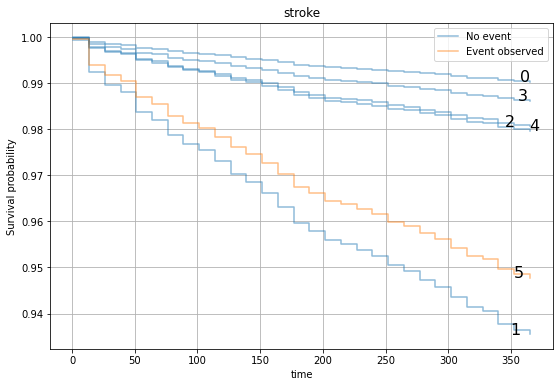

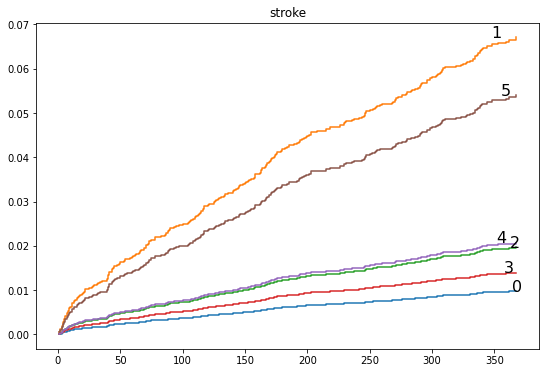

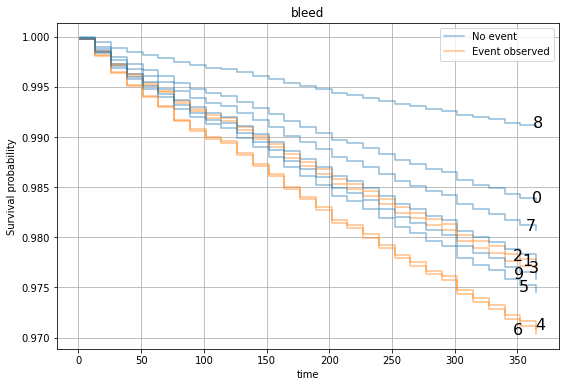

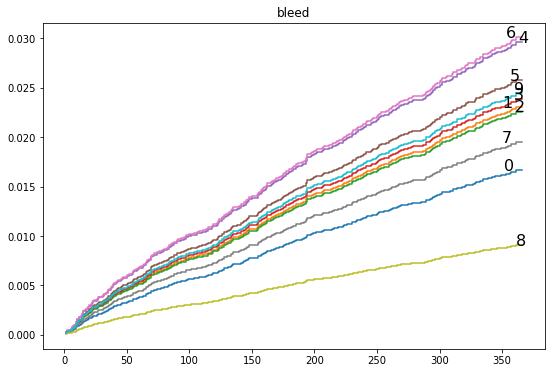

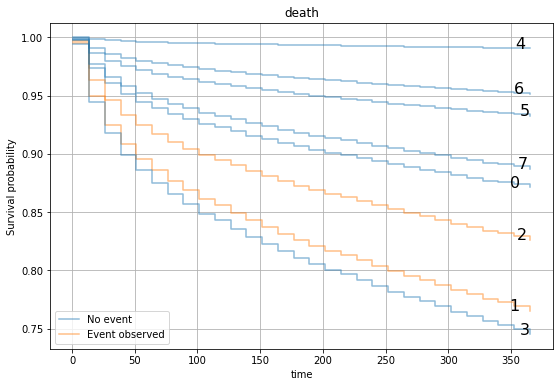

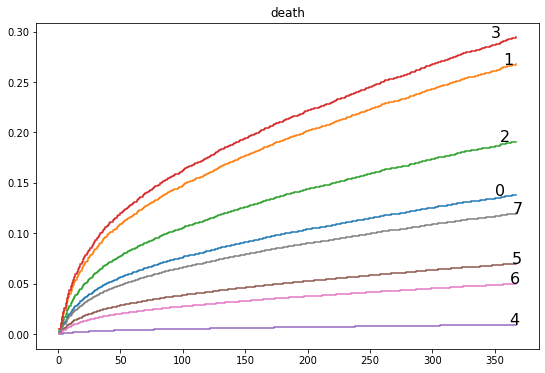

In [12]:
time_points = np.linspace( 1, query_time_endpoint, 30)

for ev in ['stroke','bleed', 'death']:
  
  curr_pt_data = Samples[ev].drop('Event?', axis=1) 
  curr_pt_data = curr_pt_data.drop('Time2Event', axis=1) 
  curr_pt_data.transpose()

  print('**'*125)
  print( 'casting predictions on', ev )

  surv_fns= models[ev].predict_survival_function( curr_pt_data.values )
  chf_fns = models[ev].predict_cumulative_hazard_function( curr_pt_data.values )

  #time_points = np.asarray( [1,12,44,120,249,445,671,894,1128,1367])  # np.quantile(  time2event[sets[0]][event_happend[0]==1], linspace(0,.6,10) )
  
  fsz=16

  def draw_survival_fns( surv_fns, df, time_points ):
      legend_handles = []
      legend_labels = []
      
      _, ax = plt.subplots(figsize=(9, 6))    
      i=-1
      for fn, label in zip(surv_fns, df.loc[:, "Event?"].astype(int)):
          i+=1
          l, = ax.step(time_points, fn(time_points), where="post",
                        color="C{:d}".format(label), alpha=0.5)
          
          plt.text( l._x[-1]-20*np.random.random(1), l._y[-1], '%d'%i, fontsize=fsz );          
          if len(legend_handles) <= label:
              name = "Event observed" if label == 1 else "No event"
              legend_labels.append(name)
              legend_handles.append(l)

      ax.legend(legend_handles, legend_labels)
      ax.set_xlabel("time")
      ax.set_ylabel("Survival probability")
      ax.grid(True)
      ax.set_title(ev)
      
  draw_survival_fns( surv_fns, Samples[ev], time_points )

  def draw_cum_hazard_fns( chf_fns ):
    _, ax = plt.subplots(figsize=(9, 6))

    for i,fn in enumerate(  chf_fns ):
        _, ax.step(fn.x[:365*NYRS], fn(fn.x[:365*NYRS]), where="post");
        
        n=len(fn.x[:365*NYRS])

        r1,r2,r3= fn(fn.x[:365])[-1], fn(fn.x[:2*365])[-1], fn(fn.x[:365*3][-1]) 
        print( 'Sample patient {0} has cumulative risks of {{{1:.2f},{2:.2f},{3:.2f}}} for event at years 1,2,3'.format( i, r1,r2,r3 )  )   
        ax.text( n-20*np.random.random(1), fn(fn.x[:NYRS*365])[-1], '%d'%i, fontsize=fsz );      
        
        #ax.set_ylim(0,1)  
        ax.grid( axis='both', b=True, which='minor', color='grey', linestyle='-')
        ax.set_title(ev)

  draw_cum_hazard_fns( chf_fns )     